In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus as pp
import seaborn as sns

from IPython.display import display
from IPython.display import Image

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

In [2]:
class CONFIG:
    INDEXS = ["R2 Pred", "R2", "EV", "ME", "MEAN_AE", "MSE", "MEDIAN_AE", "HIT@10", "HIT@100"]

# Load Dataset

In [3]:
header = pd.read_csv("Dataset/header.csv", header=None)
header

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable


In [4]:
training_dataset = pd.read_csv("Dataset/Training/Features_Variant_5.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])
training_dataset.sample(n=10)

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
169504,70695,0,7237,18,0.0,358.0,28.561905,12.0,42.869530,0.0,...,0,0,0,0,0,1,0,0,0,0
51397,5200467,1,123640,9,0.0,792.0,197.266667,122.5,197.294382,0.0,...,0,0,0,0,0,0,0,1,0,58
42268,2071999,156,150355,57,0.0,504.0,24.268775,12.0,49.660616,0.0,...,0,0,0,0,0,0,1,0,0,0
87012,14691,0,4072,16,0.0,704.0,31.367206,9.0,77.067329,0.0,...,1,0,1,0,0,0,0,0,0,0
42373,105937,0,835,8,0.0,35.0,6.060185,5.0,5.637268,0.0,...,0,0,0,0,0,0,1,0,0,0
166705,236881,1172,36034,40,0.0,462.0,26.549038,9.0,40.872901,0.0,...,0,0,0,0,1,0,0,0,0,15
59129,358398,0,8153,18,0.0,291.0,34.222923,25.0,32.956600,0.0,...,1,0,0,0,0,0,0,1,0,2
94819,6379081,0,54297,24,0.0,818.0,96.355114,36.0,132.872361,0.0,...,0,1,1,0,0,0,0,0,0,3
28992,3611,0,16,45,0.0,6.0,0.283262,0.0,0.965732,0.0,...,0,1,0,1,0,0,0,0,0,0
107088,162,0,13,4,0.0,1.0,0.280000,0.0,0.448999,0.0,...,0,0,0,0,1,0,0,0,0,0


# Data Preprocessing

In [5]:
post_published_weekday = (training_dataset["Post published weekday-Monday"]
                          + training_dataset["Post published weekday-Tuesday"]
                          + training_dataset["Post published weekday-Wednesday"]
                          + training_dataset["Post published weekday-Thursday"]
                          + training_dataset["Post published weekday-Friday"]).astype("int")
post_published_weekend = (training_dataset["Post published weekday-Sunday"]
                          + training_dataset["Post published weekday-Saturday"]).astype("int")
training_dataset.insert(46, "Post published weekday", post_published_weekday)
training_dataset.insert(47, "Post published weekend", post_published_weekend)
training_dataset.drop(
    ["Post published weekday-Saturday",
     "Post published weekday-Sunday",
     "Post published weekday-Monday",
     "Post published weekday-Tuesday",
     "Post published weekday-Wednesday",
     "Post published weekday-Thursday",
     "Post published weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,0,1,0,0,17


In [6]:
base_datetime_weekday = (training_dataset["Base DateTime weekday-Monday"]
                          + training_dataset["Base DateTime weekday-Tuesday"]
                          + training_dataset["Base DateTime weekday-Wednesday"]
                          + training_dataset["Base DateTime weekday-Thursday"]
                          + training_dataset["Base DateTime weekday-Friday"]).astype("int")
base_datetime_weekend = (training_dataset["Base DateTime weekday-Sunday"]
                          + training_dataset["Base DateTime weekday-Saturday"]).astype("int")
training_dataset.insert(48, "Base DateTime weekday", base_datetime_weekday)
training_dataset.insert(49, "Base DateTime weekend", base_datetime_weekend)
training_dataset.drop(
    ["Base DateTime weekday-Saturday",
     "Base DateTime weekday-Sunday",
     "Base DateTime weekday-Monday",
     "Base DateTime weekday-Tuesday",
     "Base DateTime weekday-Wednesday",
     "Base DateTime weekday-Thursday",
     "Base DateTime weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Base time,Post length,Post Share Count,Post Promotion Status,H Local,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,25,166,2,0,24,1,0,1,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,70,132,1,0,24,1,0,0,1,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,26,133,2,0,24,1,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,67,131,1,0,24,1,0,1,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,65,142,5,0,24,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,16,77,2123,0,24,1,0,1,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,4,130,474,0,24,1,0,1,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,12,12,1511,0,24,1,0,1,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,31,149,1099,0,24,1,0,1,0,17


In [7]:
features = training_dataset.iloc[:, :43]
features

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,CC5,Base time,Post length,Post Share Count,Post Promotion Status,H Local,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,25,166,2,0,24,1,0,1,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,70,132,1,0,24,1,0,0,1
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,26,133,2,0,24,1,0,0,1
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,67,131,1,0,24,1,0,1,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,65,142,5,0,24,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1940,16,77,2123,0,24,1,0,1,0
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,155,4,130,474,0,24,1,0,1,0
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,207,12,12,1511,0,24,1,0,1,0
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,-459,31,149,1099,0,24,1,0,1,0


In [8]:
labels = training_dataset.iloc[:, -1:]
labels

,Target Variable
0,0
1,0
2,0
3,0
4,0
...,...
199025,203
199026,42
199027,51
199028,17


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.3, random_state=42)

# Cat Boost Regressor

## Model Training

In [10]:
def train_model(model):
    model.fit(X_train, y_train.values.ravel())
    predict = model.predict(X_test)
    return predict

In [11]:
def plot_test_predict(y_train, y_test, predict, axes=None, k=None):
    test_predict = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(predict.transpose())], axis=1)
    headers = ["Test", "Predict"]
    test_predict.columns = headers
    if axes is not None and k is not None:
        sns.lineplot(data=test_predict.sample(n=200), ax=axes[k]).set_title("Test Predict Curve k = " + str(k))
    else:
        sns.lineplot(data=test_predict.sample(n=200)).set_title("Test Predict Curve")
    plt.show()
    sns.residplot(x=predict, y=y_test.to_numpy(), lowess=True).set_title("Residuals")
    plt.show()
    y_test_np = y_test.to_numpy().flatten()
    sns.residplot(x=predict, y=y_test_np * (predict - y_test_np), lowess=True).set_title("Residuals")
    plt.show()

## Model Evaluation

In [12]:
def evaluate(model, X_test, y_test, predict):

    # R-Squared Prediction
    r2_pred = model.score(X_test, y_test)
    
    # R-Squared
    r2 = r2_score(y_test, predict)
    
    # Explained Variance Score
    ev = explained_variance_score(y_test, predict)
    
    # Max Error
    me = max_error(y_test, predict)
    
    # Mean Absolute Error
    mean_ae = mean_absolute_error(y_test, predict)
    
    # Mean Squared Error
    mse = mean_squared_error(y_test, predict)
    
    # Median Absolute Error
    median_ae = median_absolute_error(y_test, predict)
    
    # Hit@10
    y_test_np = y_test.to_numpy().flatten()
    hit = np.abs(y_test_np - predict) < 10
    hit_10 = np.sum(hit) / hit.shape[0]
    
    # Hit@100
    y_test_np = y_test.to_numpy().flatten()
    ordered_y_test = np.argsort(y_test_np)
    max_y_test = ordered_y_test[-100:]
    ordered_predict = np.argsort(predict)
    max_predict = ordered_predict[-100:]
    acc = 0
    for pred in max_predict:
        if pred in max_y_test:
            acc += 1
    hit_100 = acc / 100
    
    return r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100

## Final Model

In [13]:
def train_final_model(max_depth=None, learning_rate=0.5, n_estimators=100):
    # CatBoostRegressor
    model = CatBoostRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42,
    )

    # Model Training
    predict = train_model(model)
    plot_test_predict(y_train, y_test, predict)

    # Model Evaluation
    r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, X_test, y_test, predict)

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2_pred, r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)

0:	learn: 33.2721061	total: 278ms	remaining: 16.4s
1:	learn: 31.6284839	total: 534ms	remaining: 15.5s
2:	learn: 30.1660323	total: 752ms	remaining: 14.3s
3:	learn: 28.8420508	total: 974ms	remaining: 13.6s
4:	learn: 27.6059002	total: 1.18s	remaining: 13s
5:	learn: 26.5406853	total: 1.43s	remaining: 12.8s
6:	learn: 25.6194443	total: 1.68s	remaining: 12.7s
7:	learn: 24.7895815	total: 1.92s	remaining: 12.5s
8:	learn: 24.0143076	total: 2.15s	remaining: 12.2s
9:	learn: 23.3274053	total: 2.36s	remaining: 11.8s
10:	learn: 22.6690621	total: 2.61s	remaining: 11.6s
11:	learn: 22.1042970	total: 2.84s	remaining: 11.4s
12:	learn: 21.5933482	total: 3.04s	remaining: 11s
13:	learn: 21.1033404	total: 3.26s	remaining: 10.7s
14:	learn: 20.6929940	total: 3.47s	remaining: 10.4s
15:	learn: 20.2781899	total: 3.69s	remaining: 10.2s
16:	learn: 19.9072129	total: 3.9s	remaining: 9.86s
17:	learn: 19.5739807	total: 4.11s	remaining: 9.58s
18:	learn: 19.2368983	total: 4.33s	remaining: 9.34s
19:	learn: 18.9466907	total

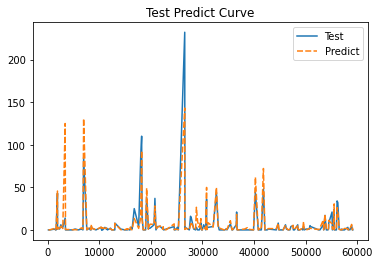

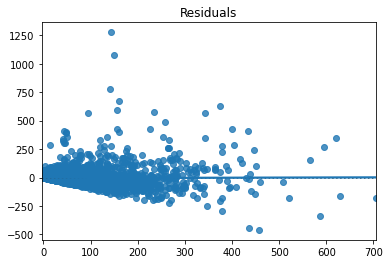

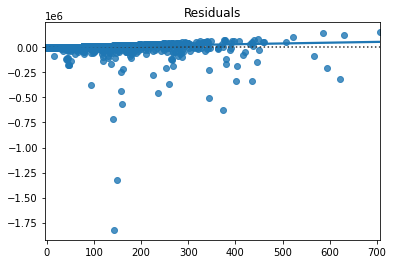

       Index          Mean
0    R2 Pred -96778.308869
1         R2      0.695260
2         EV      0.695267
3         ME   1285.527490
4    MEAN_AE      3.655953
5        MSE    312.699609
6  MEDIAN_AE      0.610371
7     HIT@10      0.932406
8    HIT@100      0.530000


In [14]:
train_final_model(max_depth=12, learning_rate=0.1, n_estimators=60)